In [1]:
# Explore success prediction for github repository

In [2]:
import sklearn as sk

In [486]:
import os
import time
import datetime
import json
import pandas as pd
from tqdm import tqdm

In [530]:
def get_ddl(path_name:str, id_repo=None)->list:
    """
    Extract download count for each release of a repo
    
    @params:
        path_name: path for the json file *my_repo*_release.json
        id_repo: id to identify the repo
    """
    
    if not id_repo:
        id_repo = path_name[:-14]
    extract_release_clean = {
        'repository': id_repo,
        'id': None,
        'name': None,
        'published_at': None,
        'download_count': 0
        }
    output = []
    
    with open(os.path.join(data, path_name)) as fd:
        release_list =  json.load(fd)
        for release in release_list:
            extract_release = extract_release_clean.copy()
            extract_release['id'] = release['id']
            extract_release['name'] = release['name']
            extract_release['published_at'] = release['published_at']
            for asset in release['assets']:
                extract_release['download_count'] += asset.get('download_count')
                
            output.append(extract_release)
    
    
    return output

# id, name, published_at, download_count

In [531]:
def get_activity(path_name:str, id_repo=None)->list:
    """
    Extract commit and author for each release of a repo
    
    @params:
        path_name: path for the json file *my_repo*_release.json
        id_repo: id to identify the repo
    """
    if not id_repo:
        id_repo = path_name[:-14]
    extract_commit_clean = {
        'repository': id_repo,
        'sha': None,
        'date': None,
        'author_id': None,
        'author_name': None
        }
    output = []
    
    with open(os.path.join(data, path_name)) as fd:
        commit_list =  json.load(fd)
        
        for commit in commit_list:
            extract_commit = extract_commit_clean.copy()
            extract_commit['sha'] = commit['sha']
            extract_commit['date'] = commit['commit']['author']['date']
            extract_commit['author_id'] = commit['commit']['author']['email']
            extract_commit['author_name'] = commit['commit']['author']['name']
            
            output.append(extract_commit)
        return output

In [596]:
def get_contrib_by_time_delta(commits: list, time_delta=5):
    """
    Compute contributor and activity by time_delta
    
    @params:
        commits: List of commit (dict)
    """

    df = pd.DataFrame(commits).sort_values('date', ascending=True).reset_index(drop=True)
    df.date = pd.to_datetime(df.date)
    df['timedelta'] = df['date'] - df['date'][0]
    
    delta = datetime.timedelta(days=time_delta)
    df['cat_timedelta'] = dft['timedelta'] // delta
    
    df_by_time =  df.groupby(by='cat_timedelta').nunique()[['sha', 'author_id']].copy()
    
    return df, df_by_time

In [533]:
data = "./data/data/"  # folder holder of json 
output_dir = "./data/fig/"  # output folder for fig

In [534]:
file_names = os.listdir(data)
df = pd.DataFrame(file_names, columns=['name'])

In [535]:
df['type'] = df.name.str.extract('.*_([A-z]+).json')
df['repo_root'] = df.name.str.extract('(.*)_[A-z]+.json')

In [536]:
df1 = df.loc[df.type == "releases"].reset_index(drop=True)

In [537]:
df = df[df['repo_root'].isin(df1.repo_root)]

In [538]:
df2 = df.loc[df.type == "commits"].reset_index(drop=True)

In [539]:
dftest = df.copy()

In [540]:
df = df.set_index(['repo_root', 'type'])
df.sort_index()

name
repo_root             type                                               
0x00-0x00_ShellPop    commits             0x00-0x00_ShellPop_commits.json
                      description     0x00-0x00_ShellPop_description.json
                      releases           0x00-0x00_ShellPop_releases.json
0xInfection_XSRFProbe commits          0xInfection_XSRFProbe_commits.json
                      description  0xInfection_XSRFProbe_description.json
...                                                                   ...
zmap_zmap             description              zmap_zmap_description.json
                      releases                    zmap_zmap_releases.json
zzzteph_kraker        commits                 zzzteph_kraker_commits.json
                      description         zzzteph_kraker_description.json
                      releases               zzzteph_kraker_releases.json

[909 rows x 1 columns]

  7%|█████████▎                                                                                                                                    | 20/303 [00:03<00:59,  4.72it/s]/var/folders/_j/3xn489rs3g1398fg6wcqrms80000gn/T/ipykernel_82047/1563172836.py:40: UserWarning: Glyph 127752 (\N{RAINBOW}) missing from current font.
  fig.tight_layout()
/var/folders/_j/3xn489rs3g1398fg6wcqrms80000gn/T/ipykernel_82047/1563172836.py:40: UserWarning: Glyph 128126 (\N{ALIEN MONSTER}) missing from current font.
  fig.tight_layout()
/var/folders/_j/3xn489rs3g1398fg6wcqrms80000gn/T/ipykernel_82047/1563172836.py:40: UserWarning: Glyph 128556 (\N{GRIMACING FACE}) missing from current font.
  fig.tight_layout()
/var/folders/_j/3xn489rs3g1398fg6wcqrms80000gn/T/ipykernel_82047/1563172836.py:41: UserWarning: Glyph 127752 (\N{RAINBOW}) missing from current font.
  fig.savefig(os.path.join(output_dir, repo_name+'_diag_de_phase.png'))
/var/folders/_j/3xn489rs3g1398fg6wcqrms80000gn/T/ipykernel_82047/1563172

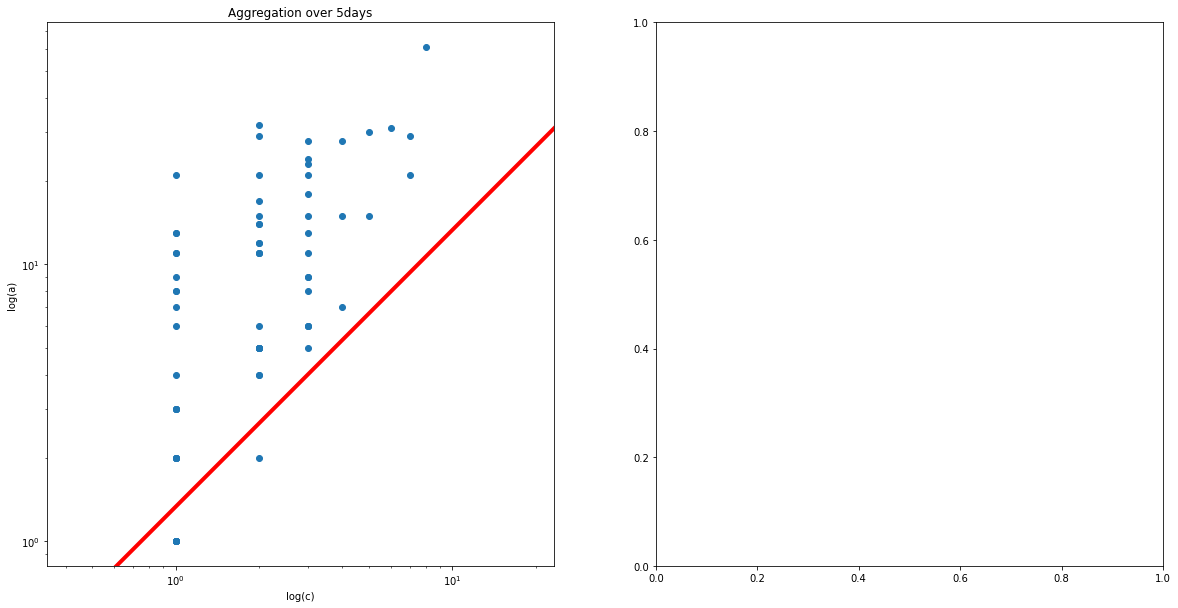

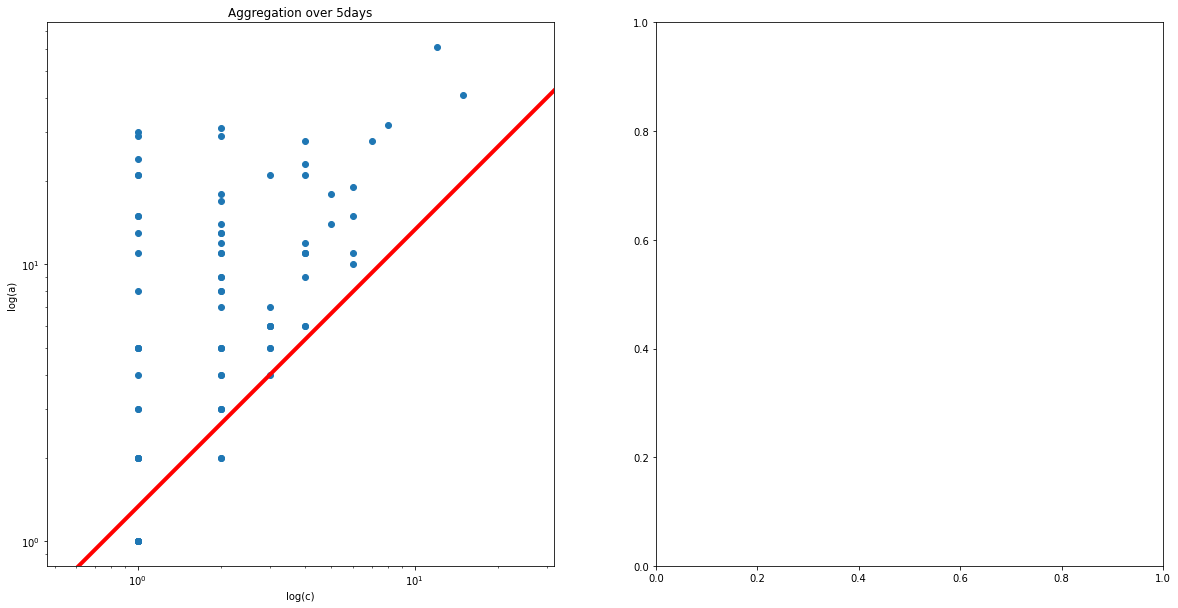

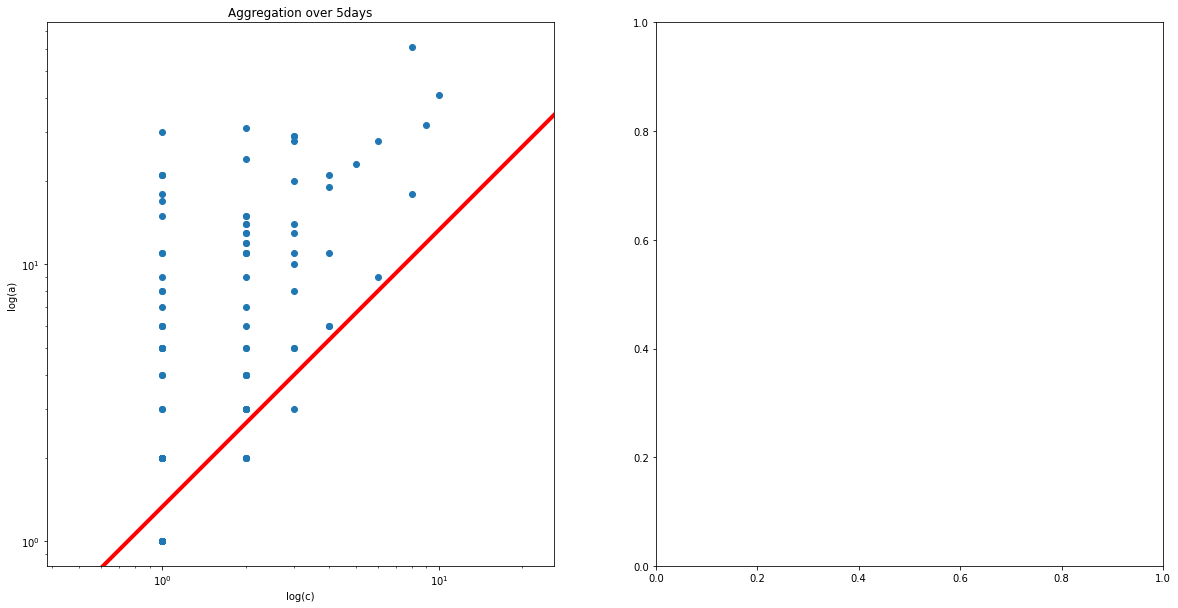

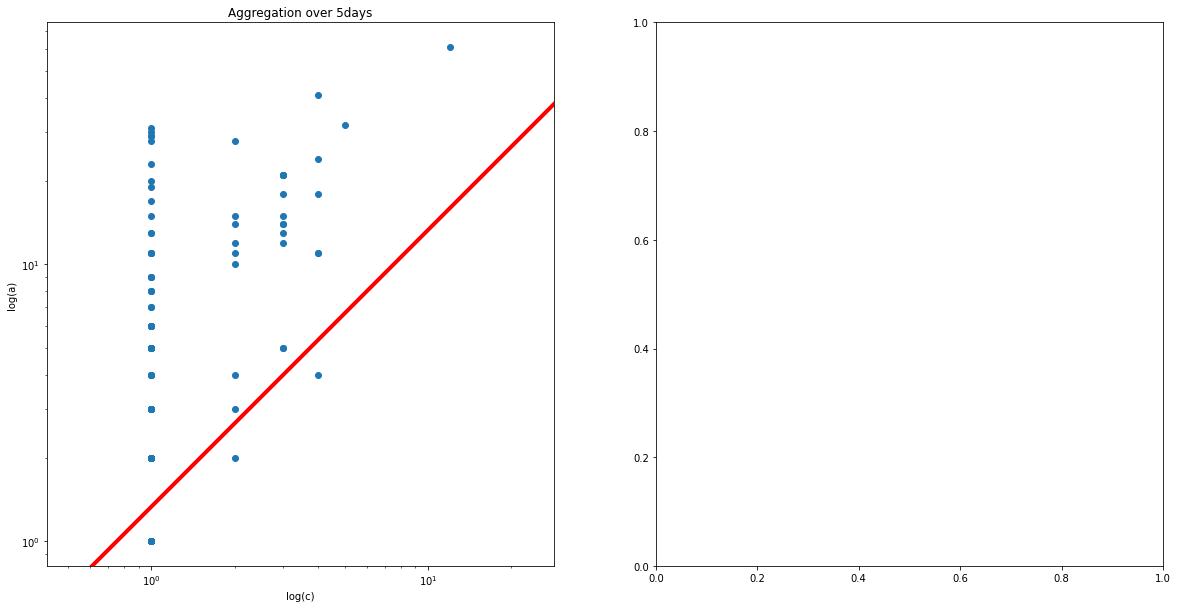

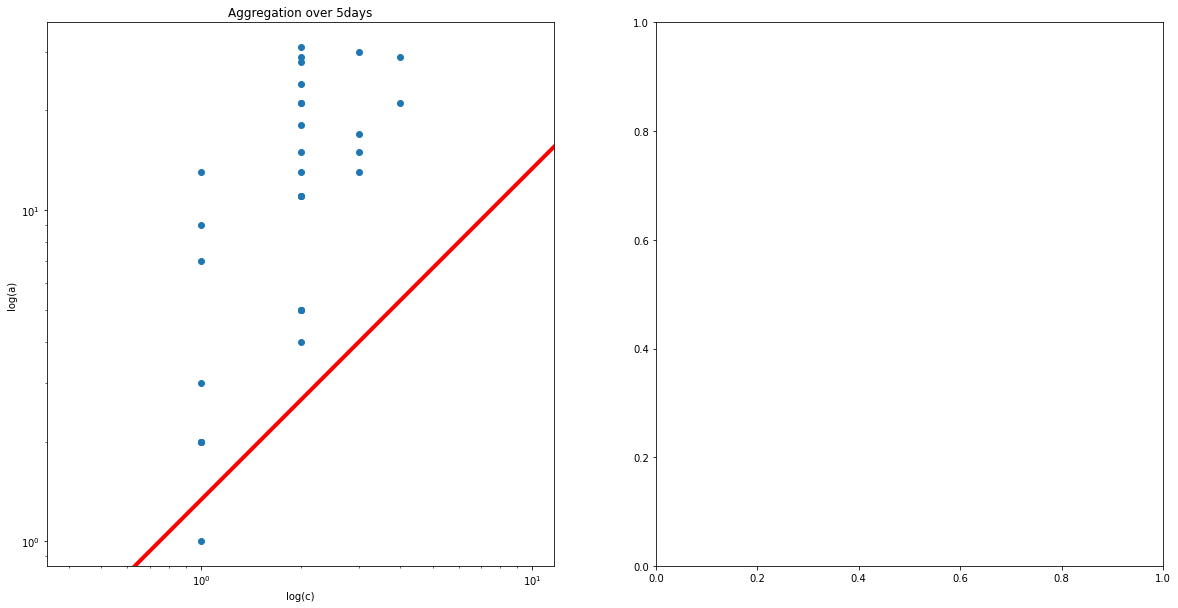

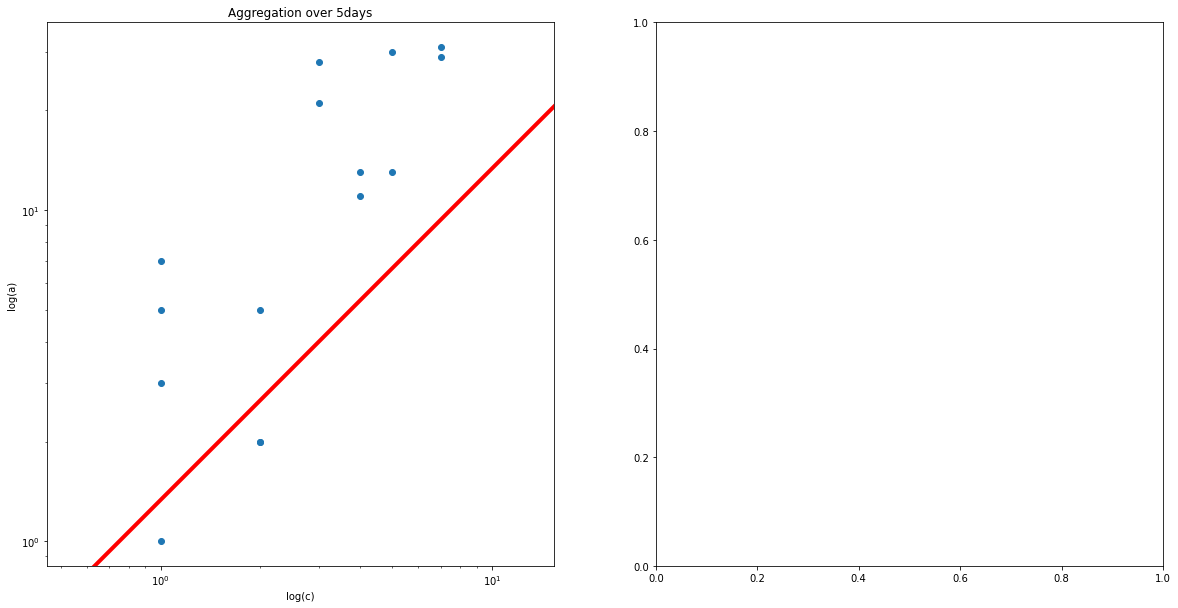

In [637]:
cpt=0
skip=0
stop=5
failed_repo = []
df_all = pd.DataFrame(columns=['name', 'nbr_unique_author', 'nbr_commit', 'max_c', 'min_c', 'len_c', 'max_a', 'min_a', 'len_a', 'max_ddl'])
for repo_name, new_df in tqdm(df.groupby(level=0)):
    try:
        if cpt<skip or cpt>stop:
            continue
        
        name = new_df.loc[repo_name, "releases"].values[0]
        ddl = get_ddl(name, id_repo=repo_name)

        xh=[]
        yh=[]
        hist=[]
        for item in ddl:
            #hist.append([item['name'],item['download_count']])
            xh.append(item['name'])
            yh.append(item['download_count'])

        if max(yh)==0:
            continue

        name = new_df.loc[repo_name, "commits"].values[0]
        activity = get_activity(name, id_repo=repo_name)
        df_contrib, df_timedelta = get_contrib_by_time_delta(activity, time_delta=5)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        x = df_timedelta['author_id'].to_list()
        y = df_timedelta['sha'].to_list()
        ax1.axline((0, 0), (1, 4/3), linewidth=4, color='r')
        ax1.scatter(x, y)
        ax1.set(xlabel='log(c)', ylabel='log(a)', title='Aggregation over 5days', xscale='log', yscale='log')
        ax1.axis('equal')



        ax2.bar(xh, yh)
        fig.tight_layout()
        fig.savefig(os.path.join(output_dir, repo_name+'_diag_de_phase.png'))
        plt.close(fig)
        
        df_all.loc[len(df_all)] = [repo_name, df_contrib.author_id.nunique(),
                            df_contrib.sha.nunique(),
                            max(x),
                            min(x),
                            len(x),
                            max(y),
                            min(y),
                            len(y),
                            max(yh)]
            #cpt +=1
    except:
        failed_repo.append(repo_name)


In [636]:
dfs = df_all.max_ddl.value_counts().sort_index()
dfs.unique()

array([1])

In [639]:
df_all.loc[df_all.name == "chaitin_xray"]

,name,nbr_unique_author,nbr_commit,max_c,min_c,len_c,max_a,min_a,len_a,max_ddl
41,chaitin_xray,125,798,27,1,72,50,1,72,39634


array([137,   1,   1,   1,   1,   1,   2,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1])

In [423]:
import matplotlib.pyplot as plt
import numpy as np

/var/folders/_j/3xn489rs3g1398fg6wcqrms80000gn/T/ipykernel_82047/1134751893.py:16: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


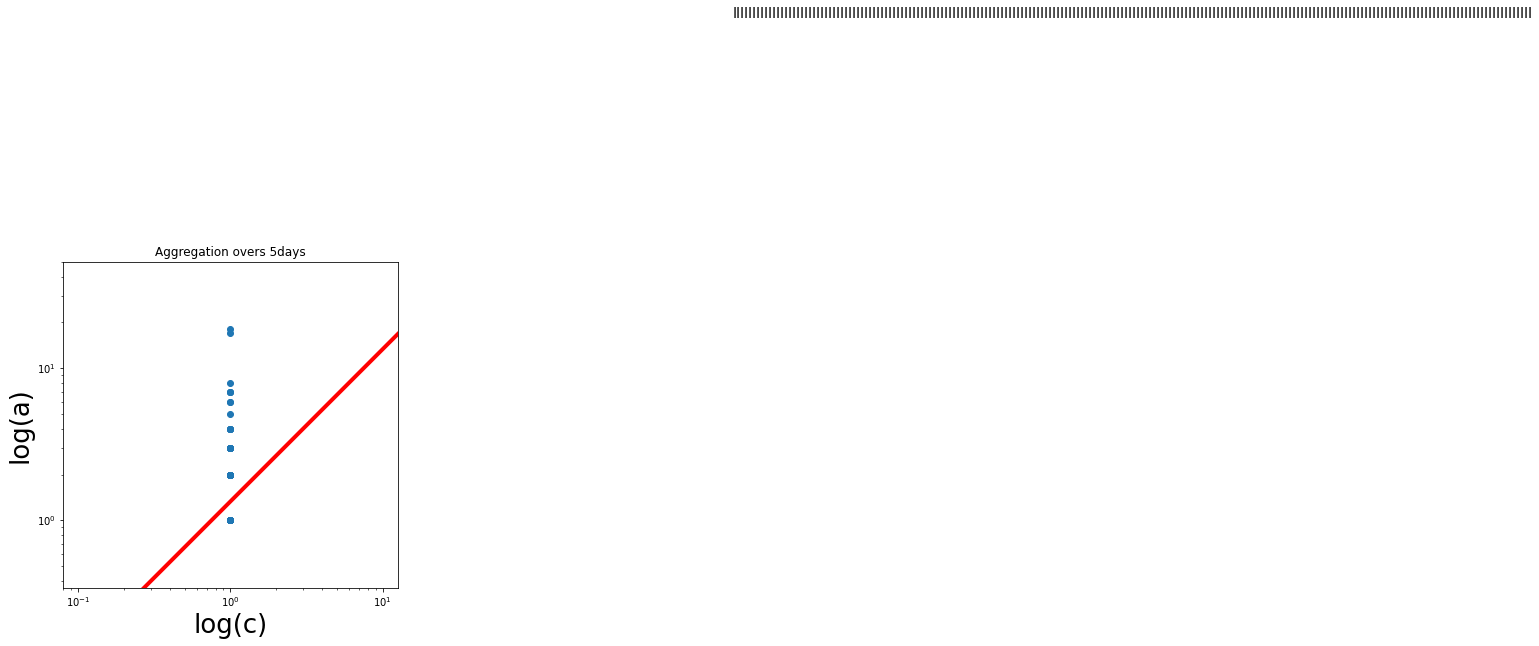

In [490]:
plt.figure(figsize=(6,6))
x = dftb['author_id'].to_list()
y = dftb['sha'].to_list()
plt.axline((0, 0), (1, 4/3), linewidth=4, color='r')
plt.scatter(x, y)
plt.xlabel('log(c)', fontsize=26)
plt.ylabel('log(a)', fontsize=26)
plt.axis('equal')
#plt.xlim(-np.pi, np.pi)
#plt.ylim(-2, 2)
plt.xscale('log')
plt.yscale('log')
plt.title('Aggregation overs 5days')
plt.text(2000, 2000, "l"*200, fontsize=14)

plt.tight_layout()
plt.show()

In [425]:
max(x)

1

In [426]:
max(y)

18